In [2]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
from sklearn.decomposition import FastICA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessClassifier




/Users/daniele/kerasenv/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


fit using GPR where we used squared exponential function as a kernel

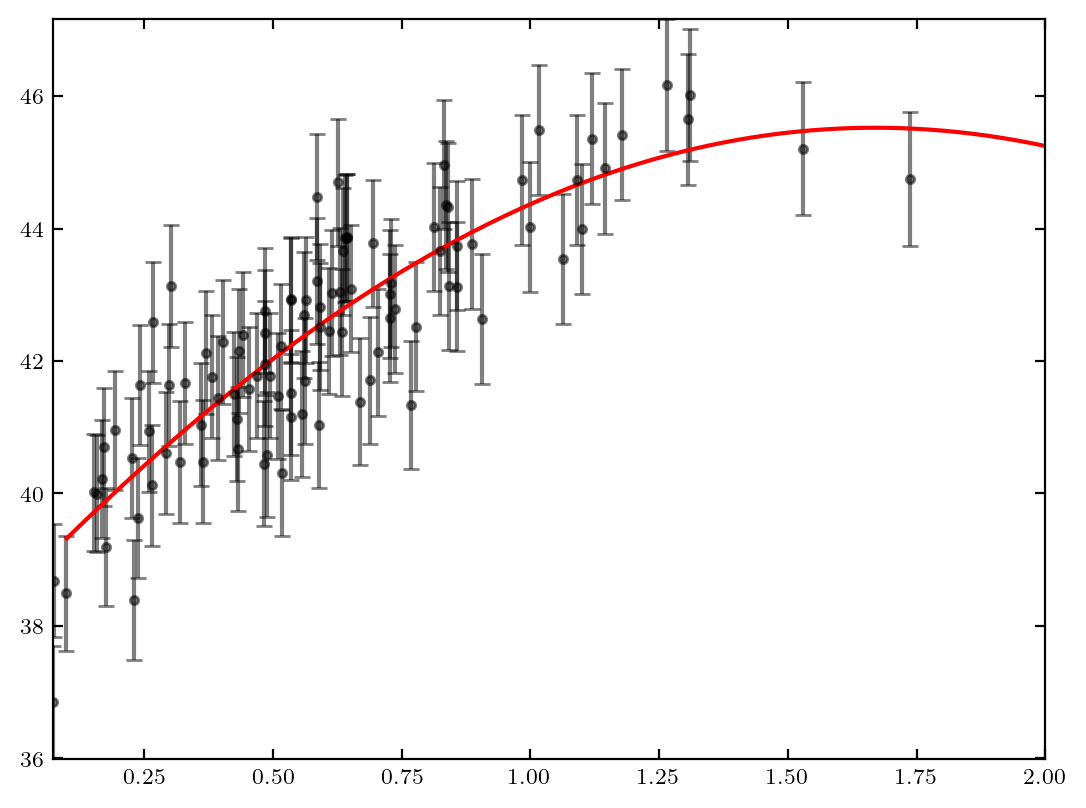

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

X=z_sample[:, np.newaxis]  # Reshape to a 2D array
xgrid= np.linspace(0.1, 2, 1000)[:, np.newaxis]  # Create a grid for predictions
kernel = ConstantKernel(1.0) * RBF(0.1) #constant kernel is a scale factor, RBF is the radial basis function kernel with length scale 0.1
gpc = GaussianProcessRegressor(kernel=kernel,alpha=dmu**2)
gpc.fit(X, mu_sample)
y_pred, dy_pred = gpc.predict(xgrid, return_std=True)
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='o', markersize=3,
             label='Data', color='black', alpha=0.5)
plt.plot(xgrid, y_pred, color='red', label='GP Mean')


In [17]:
#choosing the kernel with cross-validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, dy_train, dy_val = train_test_split(
    X, mu_sample, dmu, test_size=0.2, random_state=42)
length_scales = np.logspace(-2,1,10)
mse_val = []

for ls in length_scales:
    kernel = ConstantKernel(1.0) * RBF(length_scale=ls) 
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=dy_train**2)
    gpr.fit(X_train, y_train)
    y_pred_val = gpr.predict(X_val)
    mse_val.append(np.mean((y_val - y_pred_val)**2))

best_ls = length_scales[np.argmin(mse_val)]
print(f"Best length_scale = {best_ls}")

Best length_scale = 0.046415888336127774


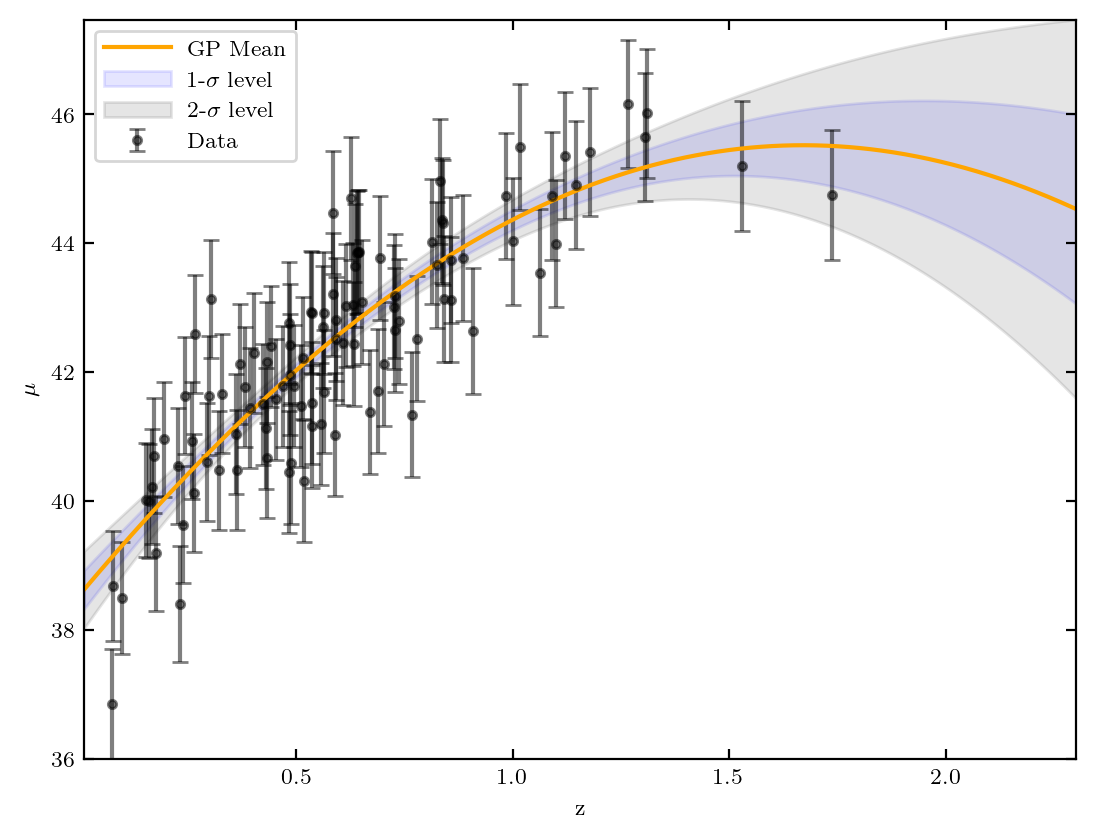

In [ ]:
kernel = ConstantKernel(1.0) * RBF(length_scale=best_ls)
gpc = GaussianProcessRegressor(kernel=kernel,alpha=dmu**2) #alpha add the noise level to the model
gpc.fit(X, mu_sample)
xgrid= np.linspace(0.01, 2.3, 1000)
y_pred, dy_pred = gpc.predict(xgrid[:,np.newaxis], return_std=True)
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='o', markersize=3,
             label='Data', color='black', alpha=0.5)
plt.plot(xgrid, y_pred, color='orange', label='GP Mean')
plt.fill_between(xgrid, y_pred - dy_pred, 
                y_pred + dy_pred,
                alpha=0.1, color='b', 
                label='1-$\sigma$ level')
plt.fill_between(xgrid, y_pred - 2*dy_pred, 
                y_pred + 2*dy_pred,
                alpha=0.1, color='k', 
                label='2-$\sigma$ level')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.legend()

# estimating H0 and Omega

In [47]:

import scipy.stats

def ptform(u):
    H0 = scipy.stats.uniform.ppf(u[0], loc=50, scale=50)    # Uniform(50,100)
    OmegaM = scipy.stats.uniform.ppf(u[1], loc=0, scale=1)  # Uniform(0,1)
    return np.array([H0, OmegaM])


from scipy.integrate import quad

def mu_theory(z, H0, OmegaM):
    c = 299792.458  # km/s
    OmegaL = 1 - OmegaM
    integral, _ = quad(lambda z_: 1/np.sqrt(OmegaM*(1+z_)**3 + OmegaL), 0, z)
    dL = (c/H0)*(1+z)*integral
    mu = 5 * np.log10(dL * 1e6 / 10)  # dL in Mpc -> pc
    return mu



In [48]:
def loglike(theta):
    H0, OmegaM = theta
    mu_model = np.array([mu_theory(z, H0, OmegaM) for z in z_sample])
    L = np.sum(((mu_sample - mu_model)/dmu)**2)
    return -0.5 * L


In [49]:
from dynesty import NestedSampler

sampler = NestedSampler(loglike, ptform, ndim=2, nlive=1000)
sampler.run_nested()

results = sampler.results


2430it [00:13, 178.64it/s, +1000 | bound: 0 | nc: 1 | ncall: 12940 | eff(%): 28.727 | loglstar:   -inf < -46.385 <    inf | logz: -48.541 +/-  0.011 | dlogz:  0.001 >  1.009]


(<Figure size 550x550 with 4 Axes>,
 array([[<Axes: title={'center': '$H_0$ = ${66.35}_{-9.85}^{+13.17}$'}>,
         <Axes: >],
        [<Axes: xlabel='$H_0$', ylabel='$\\Omega_m$'>,
         <Axes: title={'center': '$\\Omega_m$ = ${0.44}_{-0.38}^{+0.52}$'}, xlabel='$\\Omega_m$'>]],
       dtype=object))

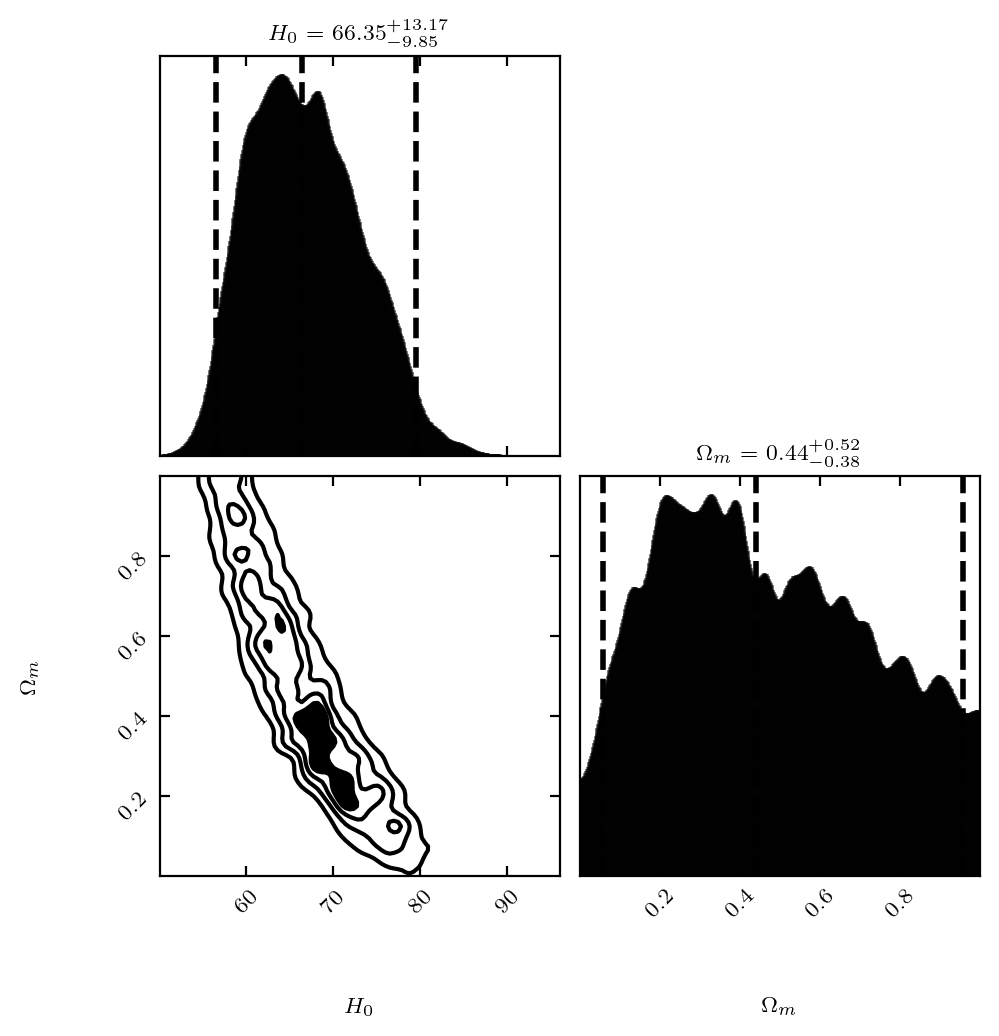

In [50]:
from dynesty import plotting as dyplot

dyplot.cornerplot(results, show_titles=True, title_fmt=".2f",
                  labels=[r"$H_0$", r"$\Omega_m$"])



It looks like the two parameters are negative correlated.

2455it [00:12, 190.31it/s, +1000 | bound: 0 | nc: 1 | ncall: 12989 | eff(%): 28.818 | loglstar:   -inf < -47.102 <    inf | logz: -49.169 +/-    nan | dlogz:  0.001 >  1.009]


(<Figure size 340x340 with 1 Axes>,
 array([[<Axes: title={'center': '$H_0$ = ${57.78}_{-4.74}^{+5.00}$'}, xlabel='$H_0$'>]],
       dtype=object))

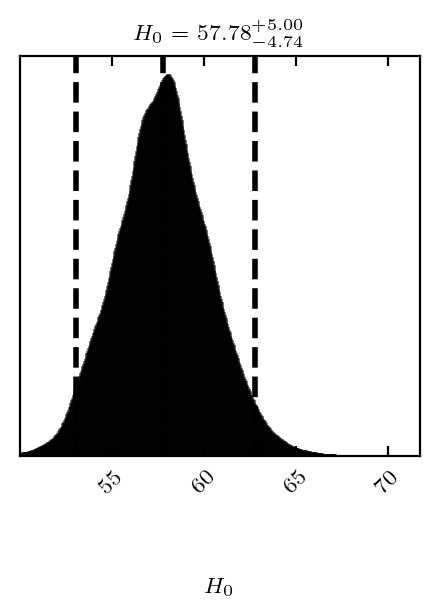

In [60]:
#now we consider omegaM=1

def ptform_2(u):
    H0 = scipy.stats.uniform.ppf(u[0], loc=50, scale=50)    # Uniform(50,100)
    # OmegaM = scipy.stats.uniform.ppf(u[1], loc=0, scale=1)  # Uniform(0,1)
    return np.array([H0])



from scipy.integrate import quad

def mu_theory_2(z, H0):
    c = 299792.458  # km/s

    integral, _ = quad(lambda zp_: 1/np.sqrt((1+zp_)**3 ), 0, z)
    dL = (c/H0)*(1+z)*integral
    mu = 5 * np.log10(dL * 1e6 / 10)  # dL in Mpc -> pc
    return mu



def loglike_2(theta):
    H0= theta[0]
    OmegaM = 1  # Fixed value
    mu_model = np.array([mu_theory(z, H0, OmegaM) for z in z_sample])
    L = np.sum(((mu_sample - mu_model)/dmu)**2)
    return -0.5 * L

from dynesty import NestedSampler

sampler_2 = NestedSampler(loglike_2, ptform_2, ndim=1, nlive=1000)
sampler_2.run_nested()

results_2 = sampler_2.results
dyplot.cornerplot(results_2, show_titles=True, title_fmt=".2f",
                  labels=[r"$H_0$"])

In [62]:
evidence1=results.logz[-1]

evidence2=results_2.logz[-1]

print("evidence first model:", np.exp(evidence1))
print("evidence second model:", np.exp(evidence2))
print("odd ratio:", np.exp(evidence1)/np.exp(evidence2))

evidence first model: 4.485878557670443e-22
evidence second model: 4.425700300121935e-22
odd ratio: 1.013597454293697


GP mean: 43.737123006897235
[39.48796642 39.36193725 38.59300023 39.76332686 38.47458954 40.12260436
 38.1296414  39.42409684 38.14669024 38.66867289 39.12067087 39.35241781
 39.32021508 38.17362535 39.03012464 39.26992914 39.13421641 37.90256101
 40.41906758 39.28611964 38.83941207 39.46307943 39.02234917 39.65333126
 39.77562096 38.58152887 39.62189474 37.91803068 38.33799145 39.60666326
 39.74611699 39.92243787 39.16948508 39.40462553 39.44592436 39.83938766
 38.83980352 40.16291637 39.88979966 39.24257096 39.79894353 38.39760974
 38.9492863  39.69130748 38.60059736 40.01954282 39.09111483 39.97450854
 39.50386498 40.47817087 41.11624479 39.98674967 38.50593741 39.02225419
 39.90186064 39.51867978 35.91318406 39.38792701 39.84719753 39.54159796
 39.31099801 38.30809212 39.12982038 39.91135987 39.01199485 38.8662149
 39.61317269 40.24927185 38.12648365 38.24445196 37.93173563 38.84163152
 41.58733299 40.6588529  39.97926147 39.81819316 40.0957726  41.60070876
 40.91620802 40.411312  

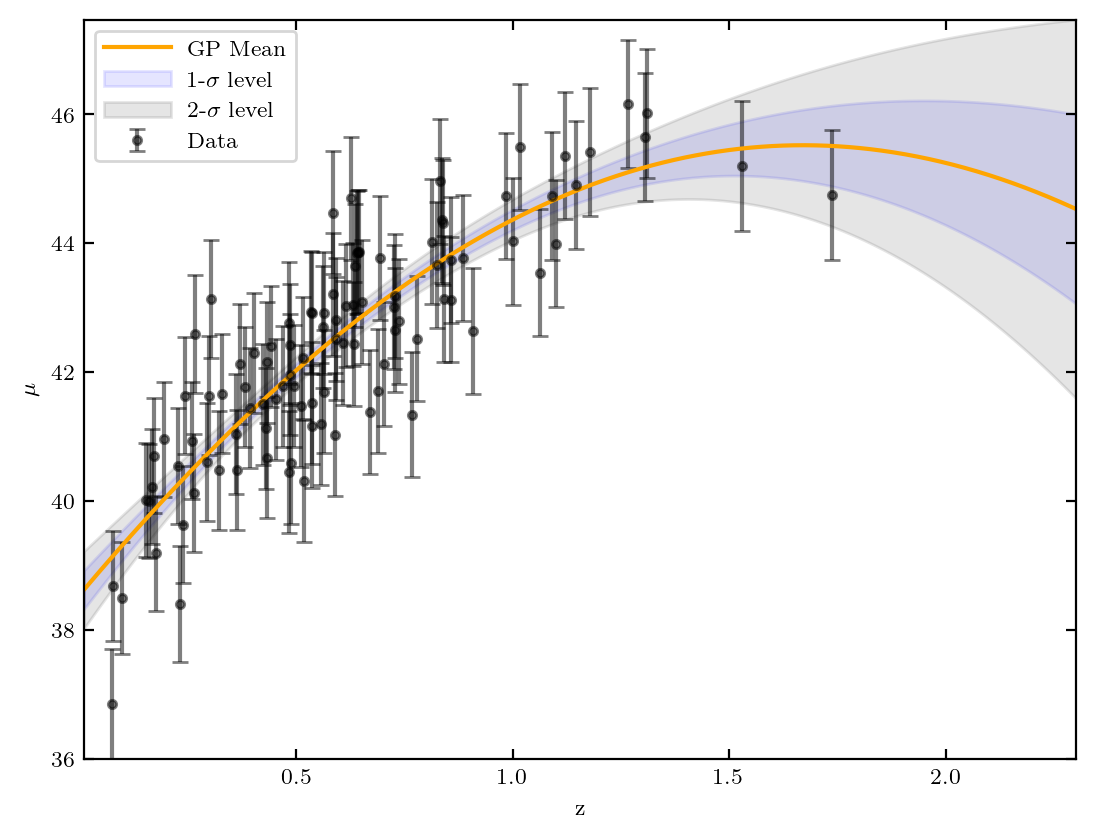

In [ ]:
kernel = ConstantKernel(1.0) * RBF(length_scale=best_ls)
gpc = GaussianProcessRegressor(kernel=kernel,alpha=dmu**2)
gpc.fit(X, mu_sample)
xgrid= np.linspace(0.01, 2.3, 1000)
y_pred, dy_pred = gpc.predict(xgrid[:,np.newaxis], return_std=True)
print("GP mean:", y_pred.mean())
mu_new_gpr = np.random.normal(y_pred, np.mean(dmu), 1000)



Using both the GPR fit and your latest CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given

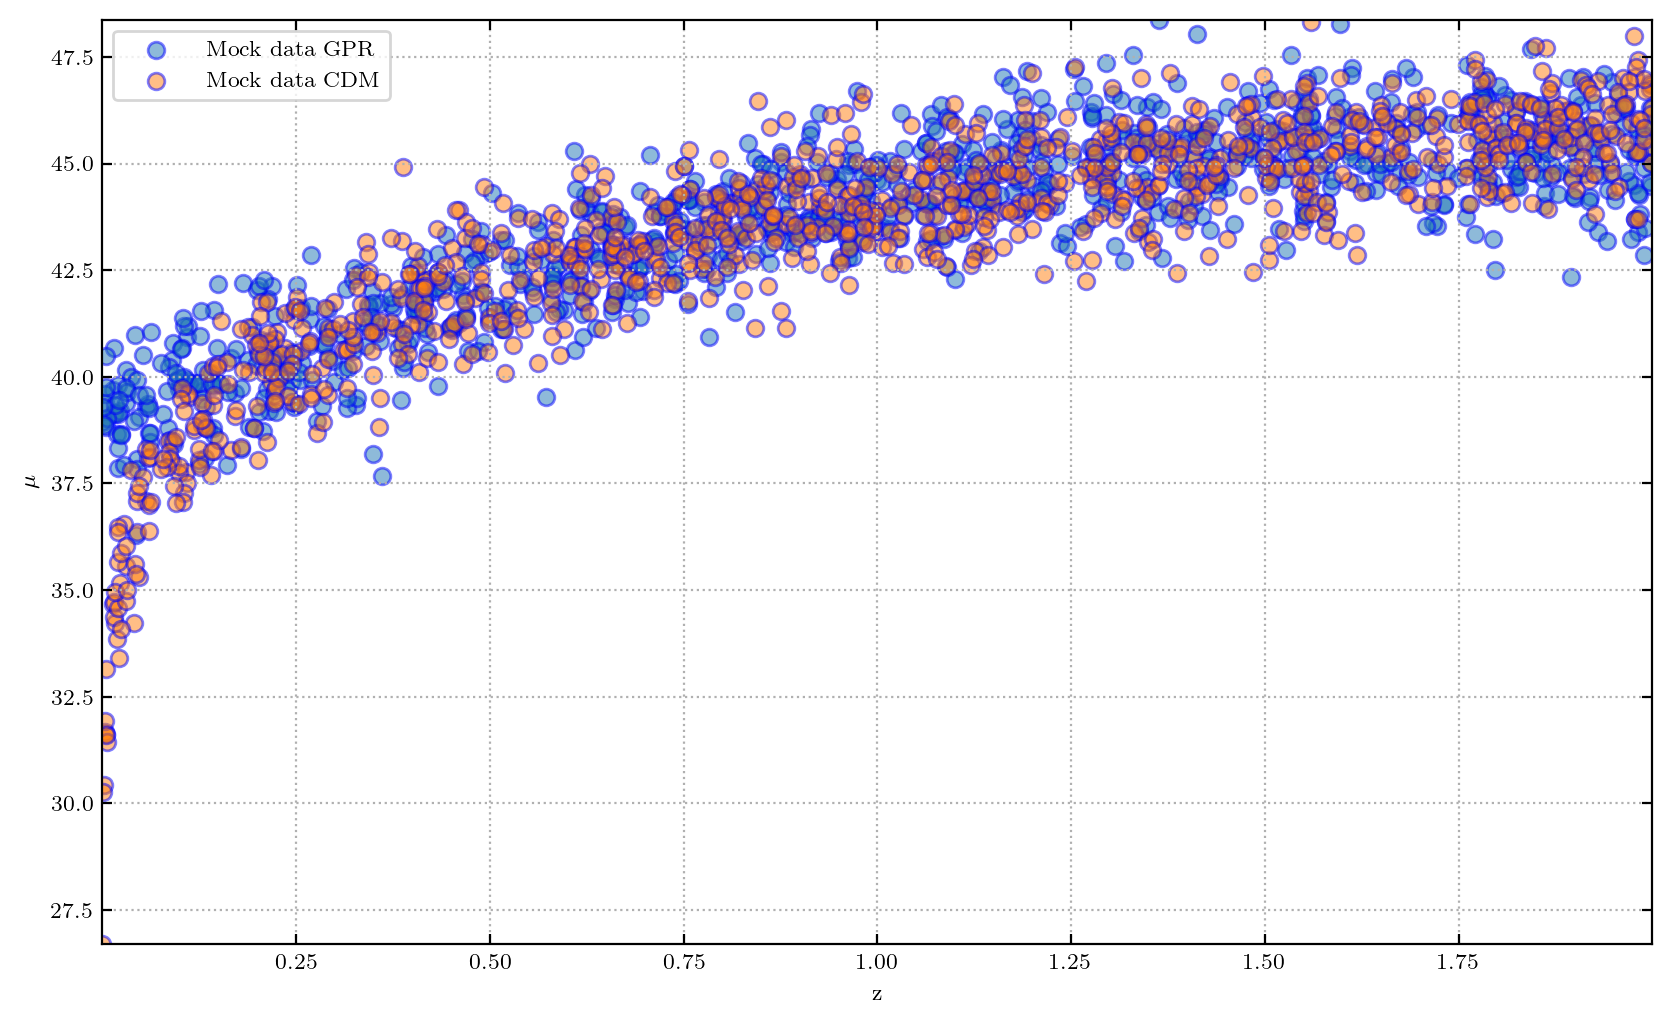

In [ ]:

N_new = 1000
z_new = np.random.uniform(0, 2, N_new) #assume a uniform distribution for the new redshifts between 0 and 2
#GPR
y_pred, y_std = gpr.predict(z_new[:,np.newaxis], return_std=True)
mu_new_gpr = np.random.normal(y_pred, np.mean(dmu), N_new)


#CDM
def mu_theory(z, H0, OmegaM):
    c = 299792.458
    OmegaL = 1 - OmegaM
    integral, _ = quad(lambda zp: 1/np.sqrt(OmegaM*(1+zp)**3 + OmegaL), 0, z)
    dL = (c / H0) * (1+z) * integral
    mu = 5 * np.log10(dL * 1e6 / 10)
    return mu

best_H0 = 66.35
best_OmegaM = 0.44
mu_new_cdm = np.array([mu_theory(z, best_H0, best_OmegaM) for z in z_new])
mu_new_cdm += np.random.normal(0, np.mean(dmu), N_new) #we add noise
dmu_new_cdm = np.full(N_new, np.mean(dmu))


plt.figure(figsize=(10,6))
plt.scatter(z_new, mu_new_gpr, alpha=0.5, label='Mock data GPR')
plt.scatter(z_new, mu_new_cdm, alpha=0.5, label='Mock data CDM')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend()
plt.grid()
plt.show()
